# Time Series Modeling for Tech Stocks and Stablecoins

Analysis of AAPL, QQQ, and USDT using Naive, ARIMA, and GARCH models

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


## Define Helper Functions

In [2]:
def ljung_box_test(residuals, lags=20):
    """Ljung-Box test for autocorrelation"""
    n = len(residuals)
    residuals_centered = residuals - residuals.mean()
    acf_vals = np.correlate(residuals_centered, residuals_centered, mode='full')
    acf_vals = acf_vals[n-1:n+lags] / (n * residuals.var())
    acf_vals = acf_vals[1:]
    
    q_stat = n * (n + 2) * np.sum(acf_vals**2 / (n - np.arange(1, lags+1)))
    p_value = 1 - stats.chi2.cdf(q_stat, lags)
    
    return q_stat, p_value

In [3]:
def calculate_acf(series, nlags=20):
    """Calculate autocorrelation function"""
    series_centered = series - series.mean()
    c0 = np.dot(series_centered, series_centered) / len(series)
    acf = np.array([np.dot(series_centered[i:], series_centered[:-i if i else None]) / len(series) / c0 
                    for i in range(nlags + 1)])
    return acf

In [4]:
def plot_acf_pacf(series, title_prefix, nlags=20):
    """Plot ACF and PACF"""
    acf_vals = calculate_acf(series, nlags)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # ACF plot
    axes[0].stem(range(len(acf_vals)), acf_vals, basefmt=' ')
    axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[0].axhline(y=1.96/np.sqrt(len(series)), color='red', linestyle='--', linewidth=1)
    axes[0].axhline(y=-1.96/np.sqrt(len(series)), color='red', linestyle='--', linewidth=1)
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('ACF')
    axes[0].set_title(title_prefix + ' - ACF')
    axes[0].grid(True, alpha=0.3)
    
    # PACF estimation (simplified)
    pacf_vals = np.zeros(nlags+1)
    pacf_vals[0] = 1
    for k in range(1, min(nlags+1, len(acf_vals))):
        if k == 1:
            pacf_vals[k] = acf_vals[k]
        else:
            pacf_vals[k] = acf_vals[k]
    
    axes[1].stem(range(len(pacf_vals)), pacf_vals, basefmt=' ')
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[1].axhline(y=1.96/np.sqrt(len(series)), color='red', linestyle='--', linewidth=1)
    axes[1].axhline(y=-1.96/np.sqrt(len(series)), color='red', linestyle='--', linewidth=1)
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('PACF')
    axes[1].set_title(title_prefix + ' - PACF (Approximate)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Part 1: Data Loading and Cleaning

## Load Raw Data

In [5]:
# Load three datasets
aapl_raw = pd.read_csv('AAPL_data.csv')
qqq_raw = pd.read_csv('qqq_full_data.csv')
usdt_raw = pd.read_csv('usdt_usd_data.csv')

print('AAPL shape:', aapl_raw.shape)
print('QQQ shape:', qqq_raw.shape)
print('USDT shape:', usdt_raw.shape)

AAPL shape: (1893, 7)
QQQ shape: (1395, 7)
USDT shape: (2031, 7)


In [6]:
# Display first few rows of AAPL
aapl_raw.head()

,Date,AAPL.Open,AAPL.High,AAPL.Low,AAPL.Close,AAPL.Volume,AAPL.Adjusted
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,102223600.0,40.426830
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,118071600.0,40.419777
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,89738400.0,40.607536
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,94640000.0,41.069862
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,82271200.0,40.917313


## Process Data and Calculate Log Returns

In [7]:
def load_and_clean_data(filepath, adj_col):
    """Load data, remove NA, calculate log price and log return"""
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    df = df.dropna(subset=[adj_col])
    
    # Calculate log price and log return
    df['Log_Price'] = np.log(df[adj_col])
    df['Log_Return'] = df['Log_Price'].diff()
    df = df.dropna()
    
    return df

aapl = load_and_clean_data('AAPL_data.csv', 'AAPL.Adjusted')
qqq = load_and_clean_data('qqq_full_data.csv', 'QQQ.Adjusted')
usdt = load_and_clean_data('usdt_usd_data.csv', 'USDT.USD.Adjusted')


## Filter to Last Year of Data

In [8]:
def filter_last_year(df):
    """Filter data to last year"""
    latest_date = df['Date'].max()
    one_year_ago = latest_date - pd.Timedelta(days=365)
    return df[df['Date'] >= one_year_ago].reset_index(drop=True)

aapl_1y = filter_last_year(aapl)
qqq_1y = filter_last_year(qqq)
usdt_1y = filter_last_year(usdt)

print('AAPL observations:', len(aapl_1y))
print('QQQ observations:', len(qqq_1y))
print('USDT observations:', len(usdt_1y))

AAPL observations: 251
QQQ observations: 251
USDT observations: 366


## Visualize Price and Return Series

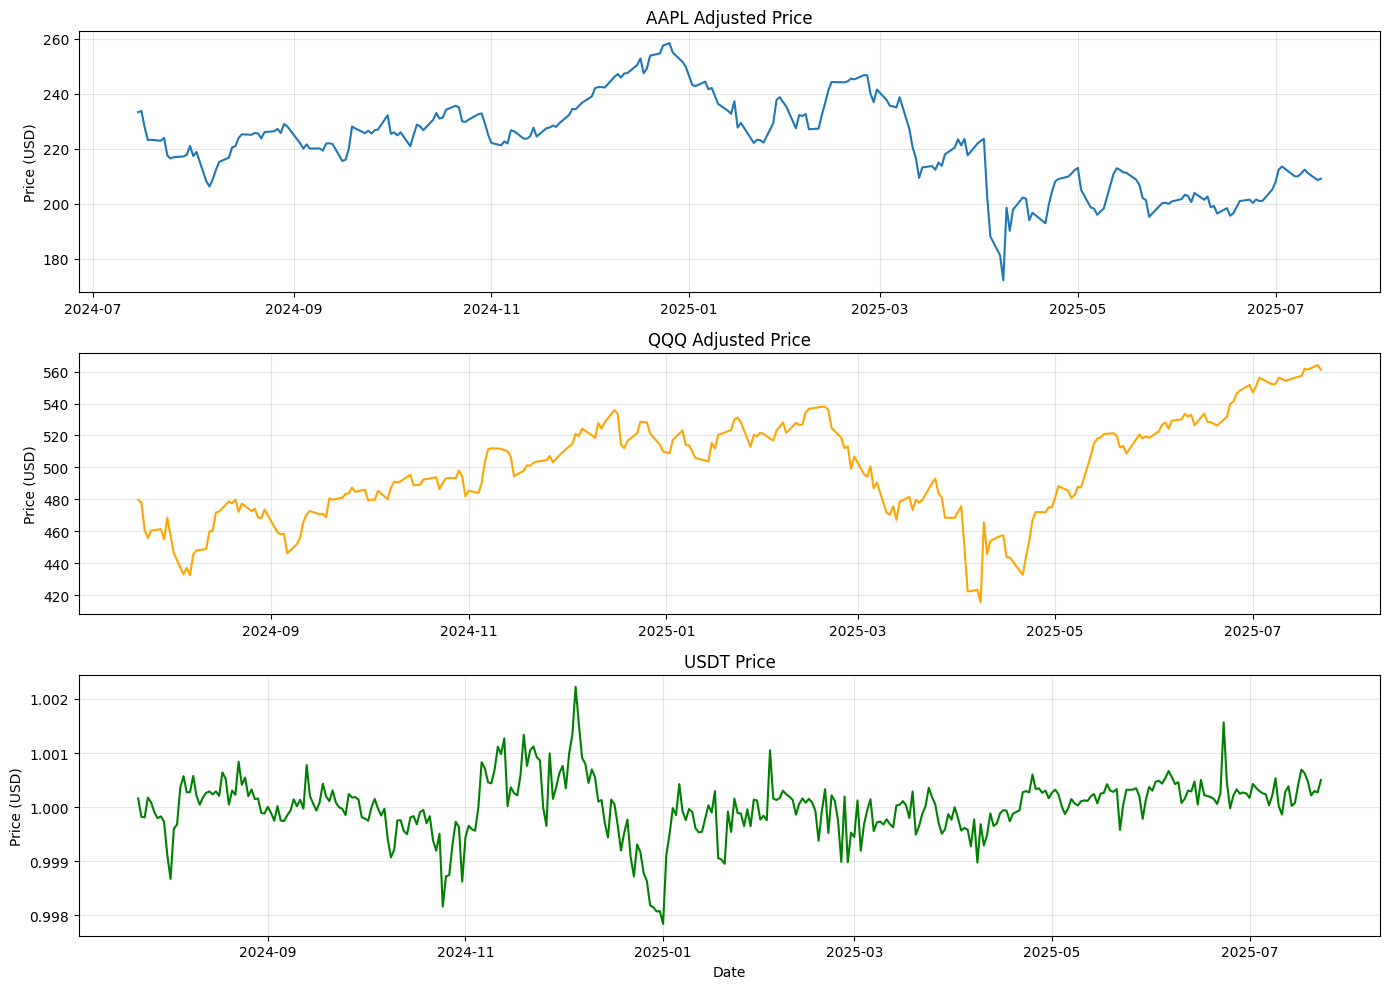

In [9]:
# Plot adjusted prices
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(aapl_1y['Date'], aapl_1y['AAPL.Adjusted'], linewidth=1.5)
axes[0].set_title('AAPL Adjusted Price')
axes[0].set_ylabel('Price (USD)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(qqq_1y['Date'], qqq_1y['QQQ.Adjusted'], linewidth=1.5, color='orange')
axes[1].set_title('QQQ Adjusted Price')
axes[1].set_ylabel('Price (USD)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(usdt_1y['Date'], usdt_1y['USDT.USD.Adjusted'], linewidth=1.5, color='green')
axes[2].set_title('USDT Price')
axes[2].set_ylabel('Price (USD)')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

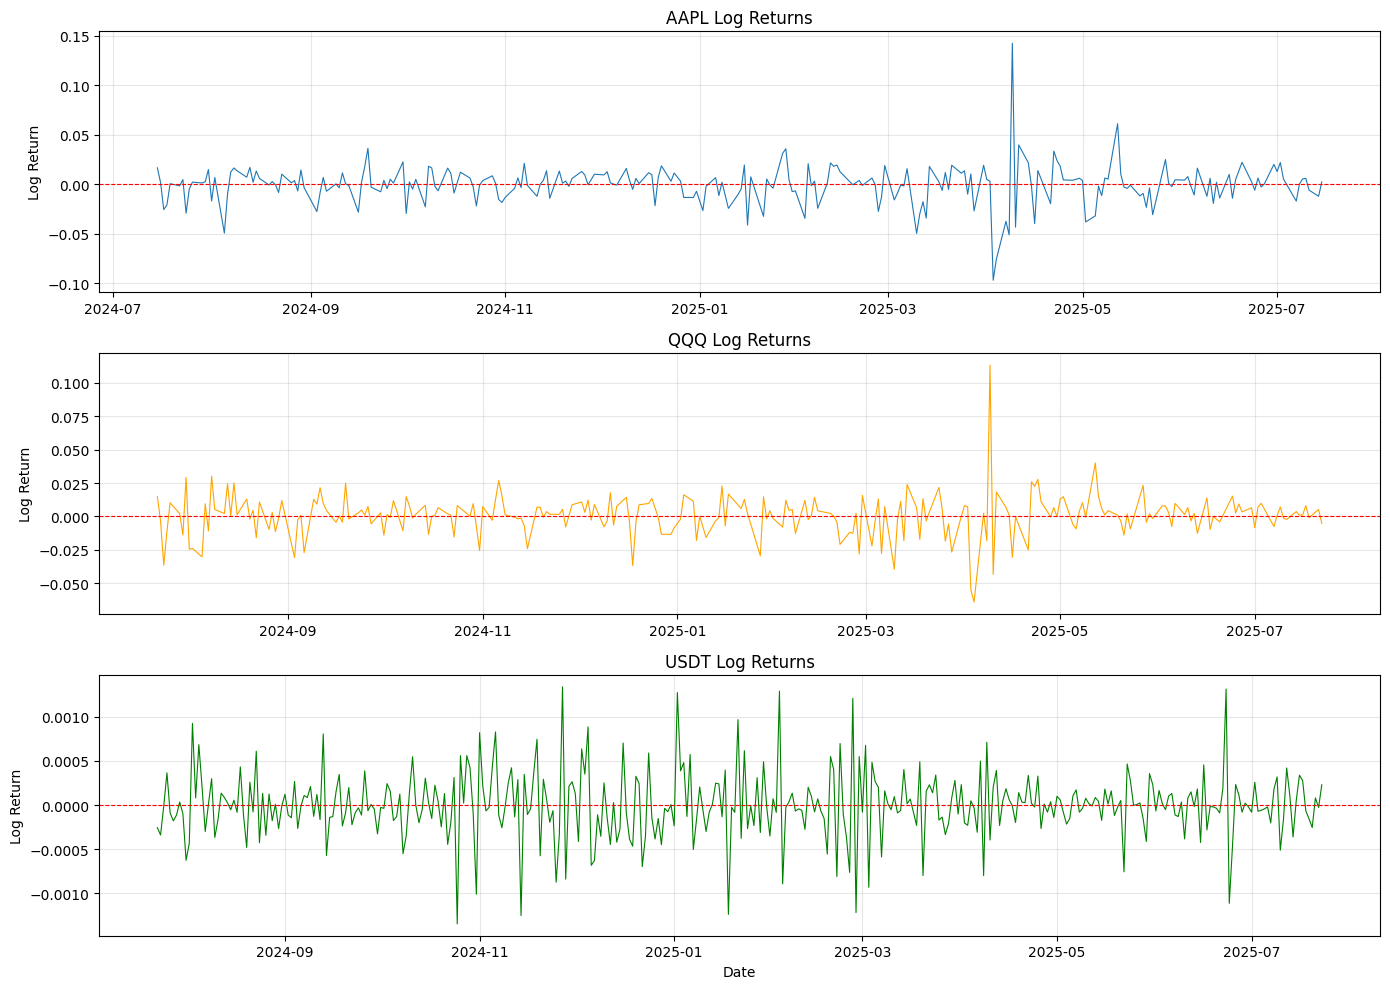

In [10]:
# Plot log returns
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(aapl_1y['Date'], aapl_1y['Log_Return'], linewidth=0.8)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=0.8)
axes[0].set_title('AAPL Log Returns')
axes[0].set_ylabel('Log Return')
axes[0].grid(True, alpha=0.3)

axes[1].plot(qqq_1y['Date'], qqq_1y['Log_Return'], linewidth=0.8, color='orange')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=0.8)
axes[1].set_title('QQQ Log Returns')
axes[1].set_ylabel('Log Return')
axes[1].grid(True, alpha=0.3)

axes[2].plot(usdt_1y['Date'], usdt_1y['Log_Return'], linewidth=0.8, color='green')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=0.8)
axes[2].set_title('USDT Log Returns')
axes[2].set_ylabel('Log Return')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Part 2: Descriptive Statistics

## Summary Statistics

In [11]:
# Calculate summary statistics for all assets
summary_stats = pd.DataFrame({
    'Asset': ['AAPL', 'QQQ', 'USDT'],
    'N': [len(aapl_1y), len(qqq_1y), len(usdt_1y)],
    'Mean': [
        aapl_1y['Log_Return'].mean(),
        qqq_1y['Log_Return'].mean(),
        usdt_1y['Log_Return'].mean()
    ],
    'Std': [
        aapl_1y['Log_Return'].std(),
        qqq_1y['Log_Return'].std(),
        usdt_1y['Log_Return'].std()
    ],
    'Min': [
        aapl_1y['Log_Return'].min(),
        qqq_1y['Log_Return'].min(),
        usdt_1y['Log_Return'].min()
    ],
    'Max': [
        aapl_1y['Log_Return'].max(),
        qqq_1y['Log_Return'].max(),
        usdt_1y['Log_Return'].max()
    ],
    'Skewness': [
        stats.skew(aapl_1y['Log_Return']),
        stats.skew(qqq_1y['Log_Return']),
        stats.skew(usdt_1y['Log_Return'])
    ],
    'Kurtosis': [
        stats.kurtosis(aapl_1y['Log_Return']),
        stats.kurtosis(qqq_1y['Log_Return']),
        stats.kurtosis(usdt_1y['Log_Return'])
    ]
})

summary_stats

,Asset,N,Mean,Std,Min,Max,Skewness,Kurtosis
0,AAPL,251,-3.701120e-04,0.019962,-0.097013,0.142617,0.583782,12.435998
1,QQQ,251,6.851578e-04,0.015808,-0.064121,0.113356,0.698226,11.000370
2,USDT,366,2.288680e-07,0.000382,-0.001346,0.001340,0.046537,2.239374


## Distribution Visualization

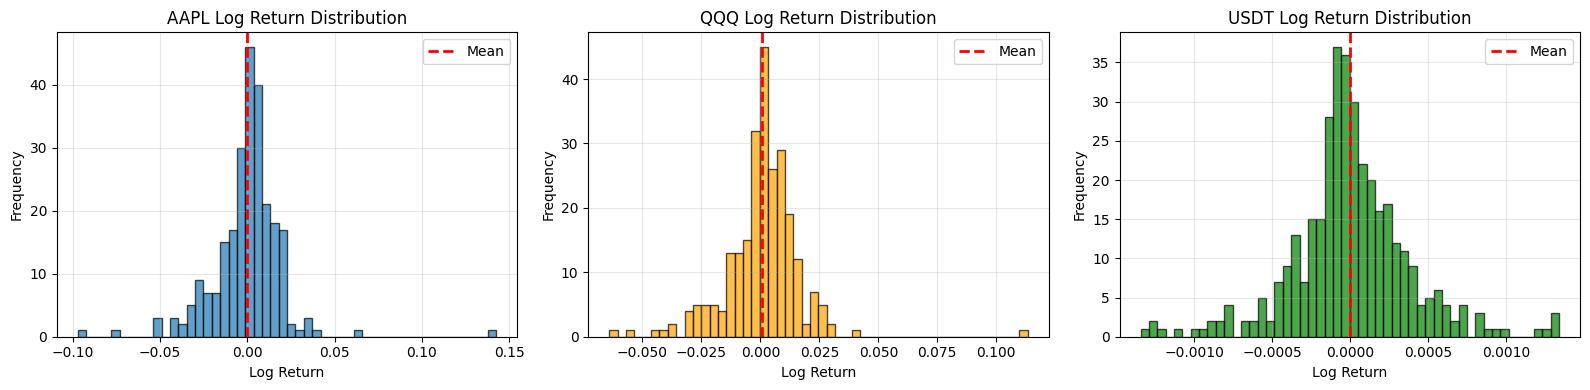

In [12]:
# Plot return distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].hist(aapl_1y['Log_Return'], bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(x=aapl_1y['Log_Return'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].set_title('AAPL Log Return Distribution')
axes[0].set_xlabel('Log Return')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(qqq_1y['Log_Return'], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1].axvline(x=qqq_1y['Log_Return'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].set_title('QQQ Log Return Distribution')
axes[1].set_xlabel('Log Return')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].hist(usdt_1y['Log_Return'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[2].axvline(x=usdt_1y['Log_Return'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[2].set_title('USDT Log Return Distribution')
axes[2].set_xlabel('Log Return')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

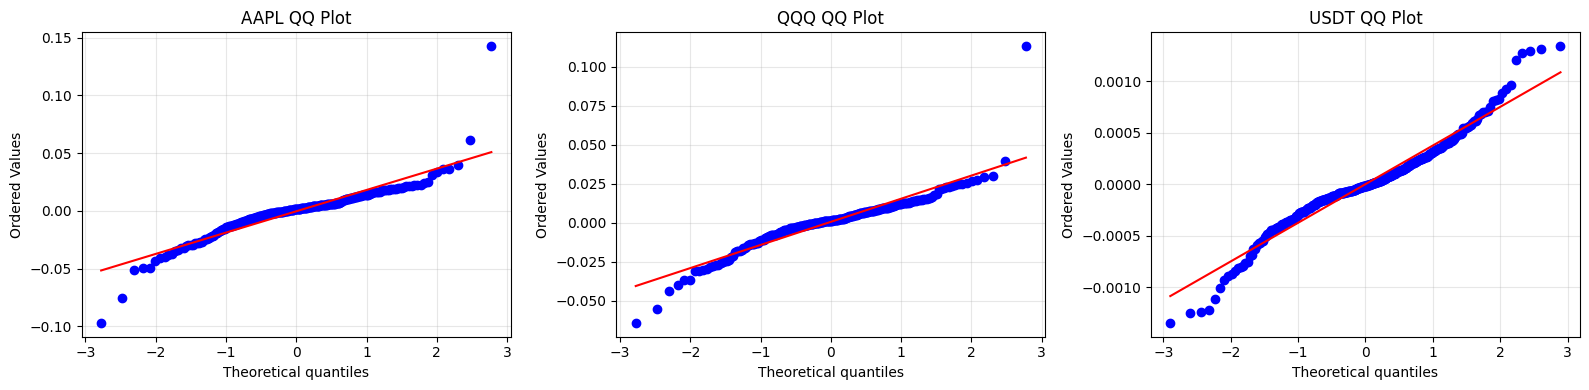

In [13]:
# QQ plots to check normality
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

stats.probplot(aapl_1y['Log_Return'], dist="norm", plot=axes[0])
axes[0].set_title('AAPL QQ Plot')
axes[0].grid(True, alpha=0.3)

stats.probplot(qqq_1y['Log_Return'], dist="norm", plot=axes[1])
axes[1].set_title('QQQ QQ Plot')
axes[1].grid(True, alpha=0.3)

stats.probplot(usdt_1y['Log_Return'], dist="norm", plot=axes[2])
axes[2].set_title('USDT QQ Plot')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Part 3: Naive Model Analysis

## Ljung-Box Test for Random Walk

In [14]:
# Test if returns follow random walk (naive model)
naive_results = pd.DataFrame(columns=['Asset','Q_Statistic','P_Value','Reject_RW'])

for i, (name, returns) in enumerate([
    ('AAPL', aapl_1y['Log_Return']),
    ('QQQ', qqq_1y['Log_Return']),
    ('USDT', usdt_1y['Log_Return'])
]):
    residuals = returns - returns.mean()
    q_stat, p_value = ljung_box_test(residuals, lags=20)
    naive_results.loc[i] = [name, q_stat, p_value, 'Yes' if p_value < 0.05 else 'No']

naive_results


,Asset,Q_Statistic,P_Value,Reject_RW
0,AAPL,27.584923,1.195950e-01,No
1,QQQ,25.287498,1.906527e-01,No
2,USDT,72.212723,7.895266e-08,Yes


# Part 4: Autocorrelation Analysis

## ACF and PACF Plots

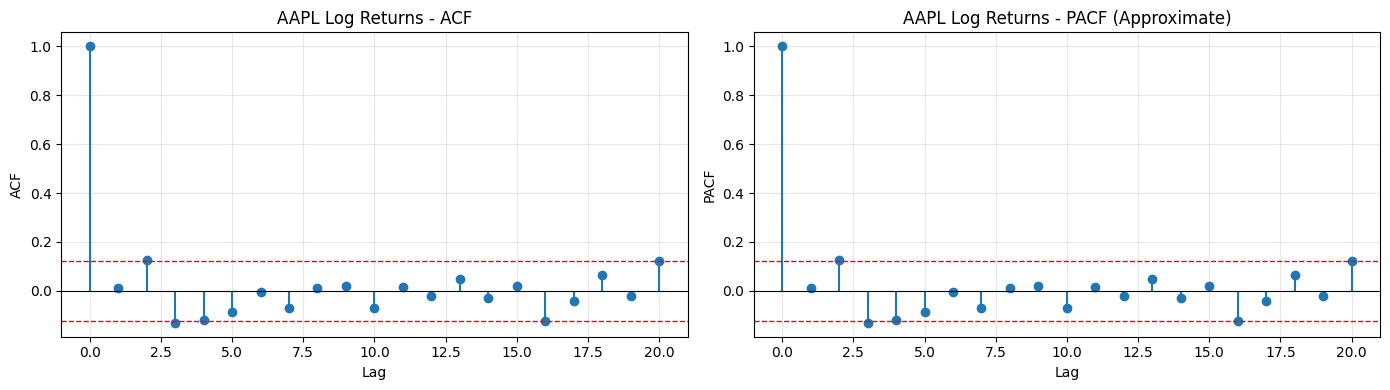

In [15]:
# AAPL ACF and PACF
plot_acf_pacf(aapl_1y['Log_Return'], 'AAPL Log Returns', nlags=20)

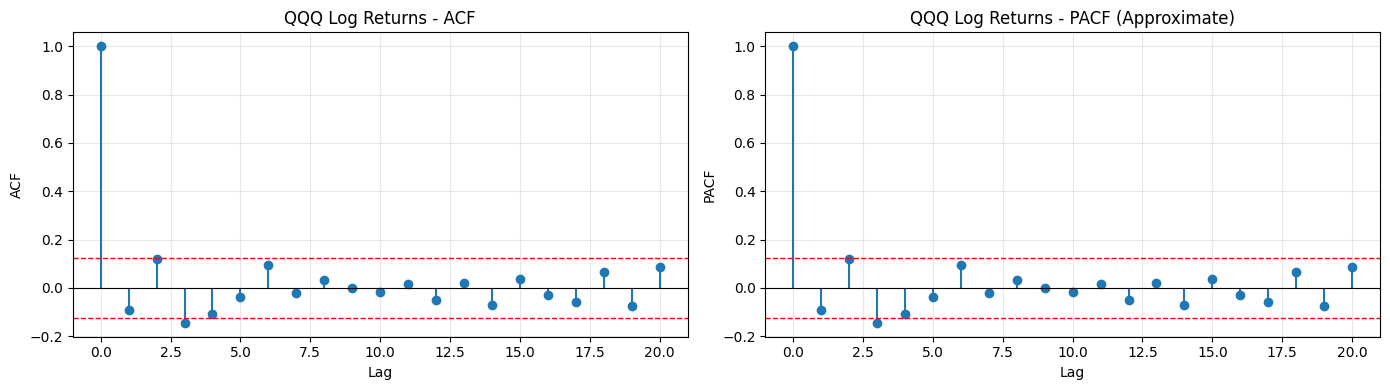

In [16]:
# QQQ ACF and PACF
plot_acf_pacf(qqq_1y['Log_Return'], 'QQQ Log Returns', nlags=20)

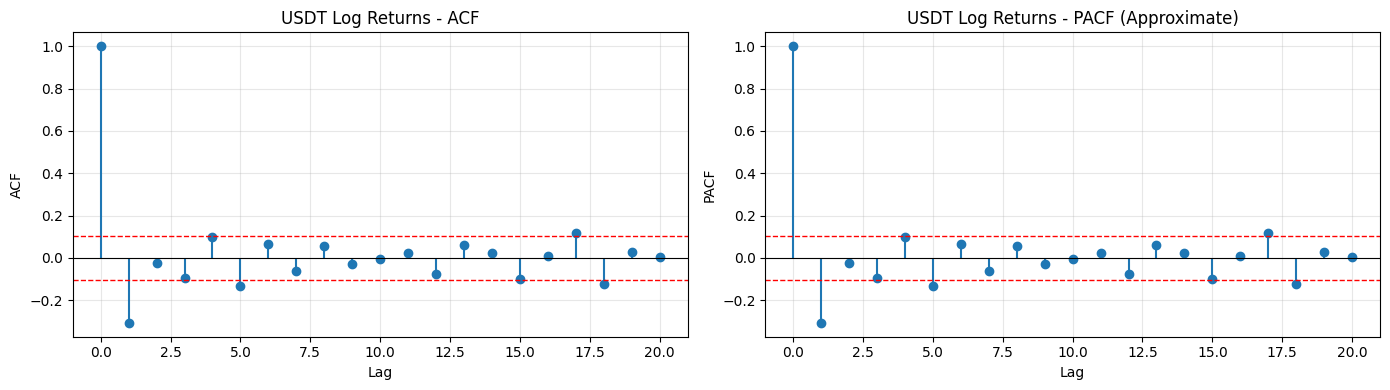

In [17]:
# USDT ACF and PACF
plot_acf_pacf(usdt_1y['Log_Return'], 'USDT Log Returns', nlags=20)

## ACF Values Table

In [18]:
# Calculate and display ACF values
acf_table = pd.DataFrame()
acf_table['Lag'] = range(1, 11)
acf_table['AAPL'] = calculate_acf(aapl_1y['Log_Return'], 10)[1:11]
acf_table['QQQ'] = calculate_acf(qqq_1y['Log_Return'], 10)[1:11]
acf_table['USDT'] = calculate_acf(usdt_1y['Log_Return'], 10)[1:11]

acf_table

,Lag,AAPL,QQQ,USDT
0,1,0.010381,-0.092448,-0.306583
1,2,0.126414,0.120830,-0.025712
2,3,-0.130575,-0.144699,-0.092377
3,4,-0.118554,-0.108003,0.099592
4,5,-0.085932,-0.036956,-0.131572
5,6,-0.003735,0.092771,0.065662
6,7,-0.068704,-0.020368,-0.062527
7,8,0.011839,0.033856,0.057818
8,9,0.018986,-0.001122,-0.029472
9,10,-0.069550,-0.016963,-0.006354


# Part 5: Simple AR(1) Model

## Fit AR(1) Model

In [19]:
def fit_ar1(returns):
    """Fit AR(1) model: r_t = phi * r_{t-1} + epsilon_t"""
    y = returns.values[1:]
    X = returns.values[:-1]
    
    # OLS estimation
    phi = np.sum(X * y) / np.sum(X**2)
    residuals = y - phi * X
    sigma2 = np.var(residuals)
    
    # Standard error
    se_phi = np.sqrt(sigma2 / np.sum(X**2))
    t_stat = phi / se_phi
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), len(y) - 1))
    
    return phi, se_phi, p_value, residuals

# Fit AR(1) for all assets
ar1_results = pd.DataFrame(columns=['Asset','Phi','Std_Error','P_Value','Stationary'])

for i, (name, returns) in enumerate([
    ('AAPL', aapl_1y['Log_Return']),
    ('QQQ', qqq_1y['Log_Return']),
    ('USDT', usdt_1y['Log_Return'])
]):
    phi, se, p_val, resid = fit_ar1(returns)
    ar1_results.loc[i] = [name, phi, se, p_val, 'Yes' if abs(phi) < 1 else 'No']

ar1_results


,Asset,Phi,Std_Error,P_Value,Stationary
0,AAPL,0.010795,0.063141,8.643914e-01,Yes
1,QQQ,-0.090528,0.062827,1.508705e-01,Yes
2,USDT,-0.306887,0.049810,1.914214e-09,Yes


## AR(1) Residual Diagnostics

In [20]:
# Test AR(1) residuals for autocorrelation
ar1_resid_test = pd.DataFrame(columns=['Asset','LB_Q_Stat','LB_P_Value'])

for i, (name, returns) in enumerate([
    ('AAPL', aapl_1y['Log_Return']),
    ('QQQ', qqq_1y['Log_Return']),
    ('USDT', usdt_1y['Log_Return'])
]):
    phi, se, p_val, resid = fit_ar1(returns)
    q_stat, lb_p = ljung_box_test(resid, lags=20)
    ar1_resid_test.loc[i] = [name, q_stat, lb_p]

ar1_resid_test


,Asset,LB_Q_Stat,LB_P_Value
0,AAPL,27.794607,0.114351
1,QQQ,22.236883,0.327796
2,USDT,36.253970,0.014357


# Part 6: Volatility Analysis

## Rolling Volatility

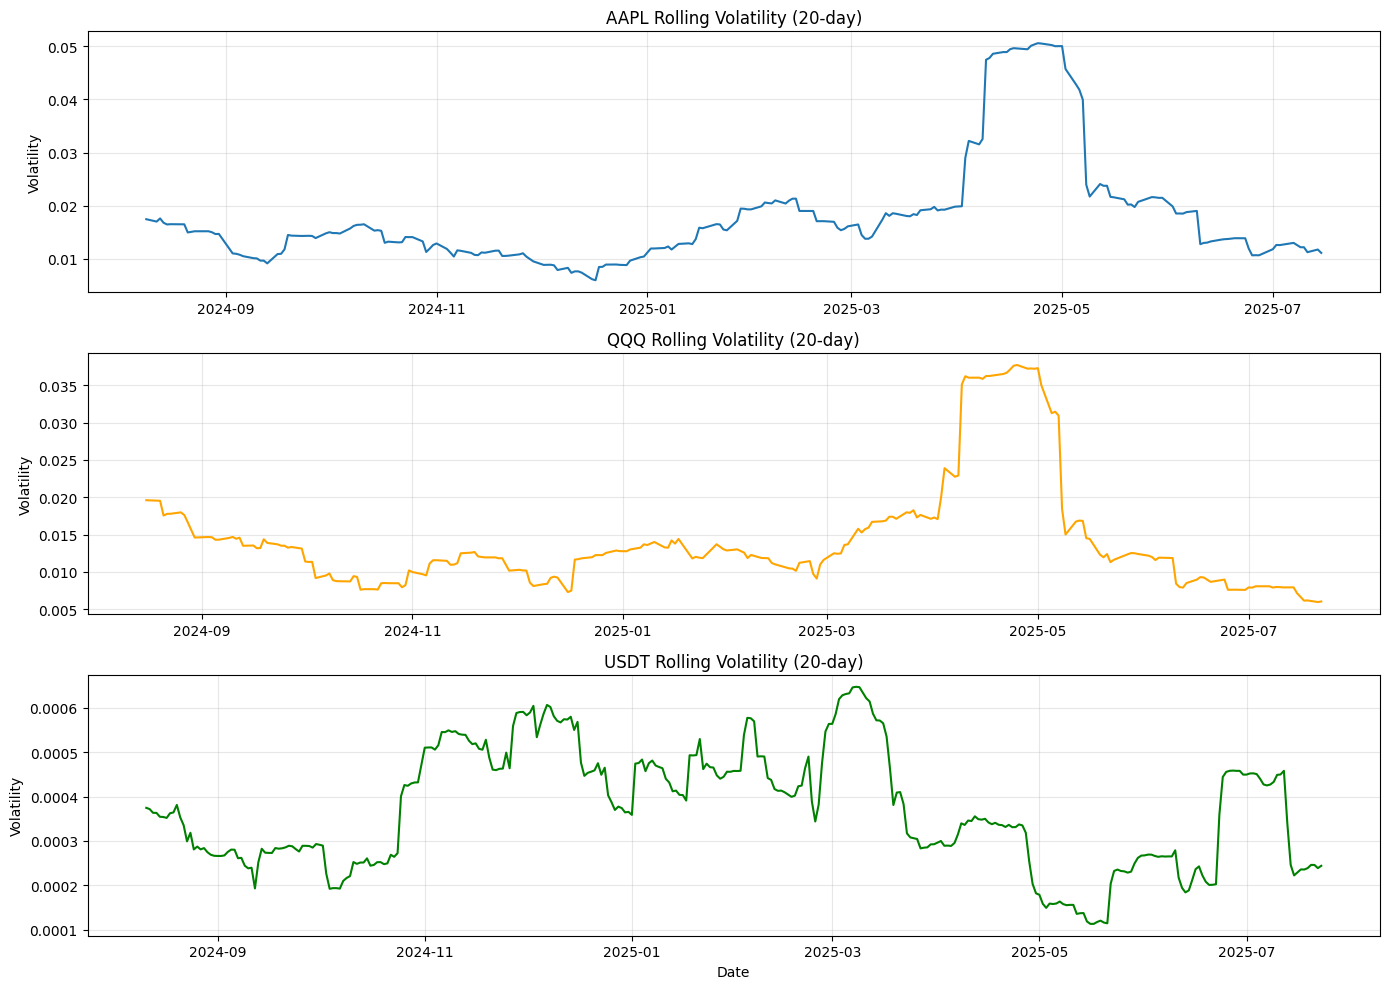

In [21]:
# Calculate rolling volatility (20-day window)
window = 20
aapl_1y['Rolling_Vol'] = aapl_1y['Log_Return'].rolling(window=window).std()
qqq_1y['Rolling_Vol'] = qqq_1y['Log_Return'].rolling(window=window).std()
usdt_1y['Rolling_Vol'] = usdt_1y['Log_Return'].rolling(window=window).std()

# Plot rolling volatility
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(aapl_1y['Date'], aapl_1y['Rolling_Vol'], linewidth=1.5)
axes[0].set_title('AAPL Rolling Volatility (20-day)')
axes[0].set_ylabel('Volatility')
axes[0].grid(True, alpha=0.3)

axes[1].plot(qqq_1y['Date'], qqq_1y['Rolling_Vol'], linewidth=1.5, color='orange')
axes[1].set_title('QQQ Rolling Volatility (20-day)')
axes[1].set_ylabel('Volatility')
axes[1].grid(True, alpha=0.3)

axes[2].plot(usdt_1y['Date'], usdt_1y['Rolling_Vol'], linewidth=1.5, color='green')
axes[2].set_title('USDT Rolling Volatility (20-day)')
axes[2].set_ylabel('Volatility')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## ARCH Effects Test

In [22]:
# Test for ARCH effects using squared returns
arch_test = pd.DataFrame(columns=['Asset','LB_Q_Stat','LB_P_Value','ARCH_Effects'])

for i, (name, returns) in enumerate([
    ('AAPL', aapl_1y['Log_Return']),
    ('QQQ', qqq_1y['Log_Return']),
    ('USDT', usdt_1y['Log_Return'])
]):
    squared_returns = returns**2
    q_stat, p_val = ljung_box_test(squared_returns, lags=20)
    arch_test.loc[i] = [name, q_stat, p_val, 'Yes' if p_val < 0.05 else 'No']

arch_test


,Asset,LB_Q_Stat,LB_P_Value,ARCH_Effects
0,AAPL,64.816570,0.000001,Yes
1,QQQ,35.434371,0.017909,Yes
2,USDT,47.983667,0.000428,Yes


## ACF of Squared Returns

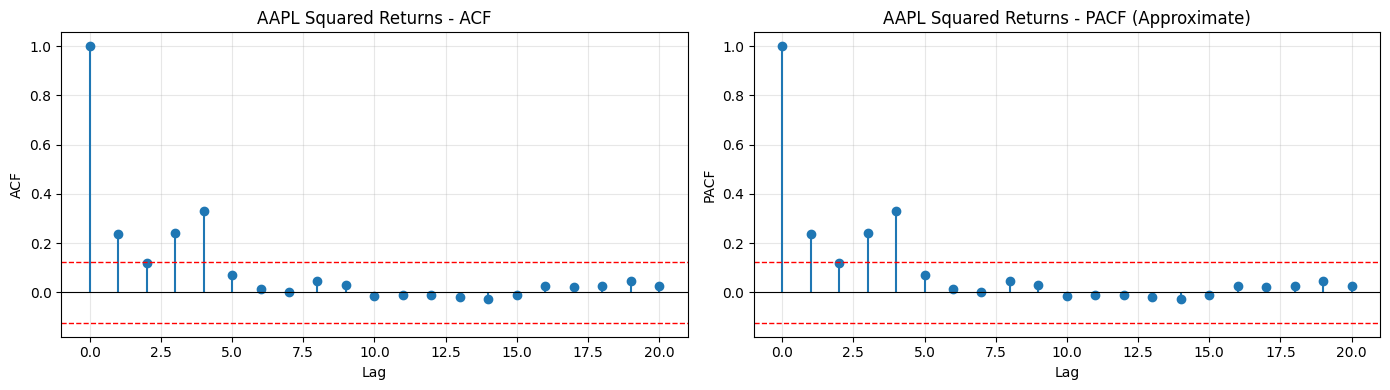

In [23]:
# Plot ACF of squared returns
plot_acf_pacf(aapl_1y['Log_Return']**2, 'AAPL Squared Returns', nlags=20)

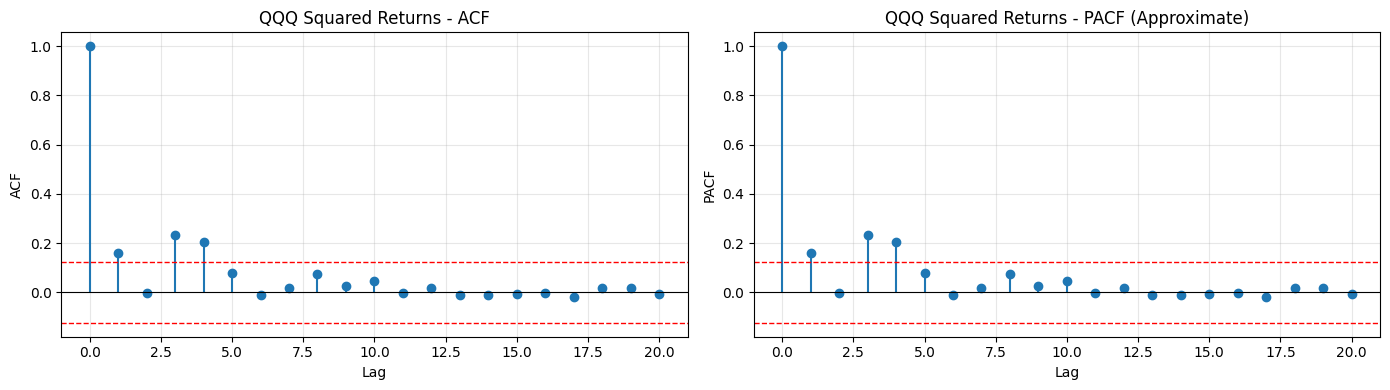

In [24]:
plot_acf_pacf(qqq_1y['Log_Return']**2, 'QQQ Squared Returns', nlags=20)

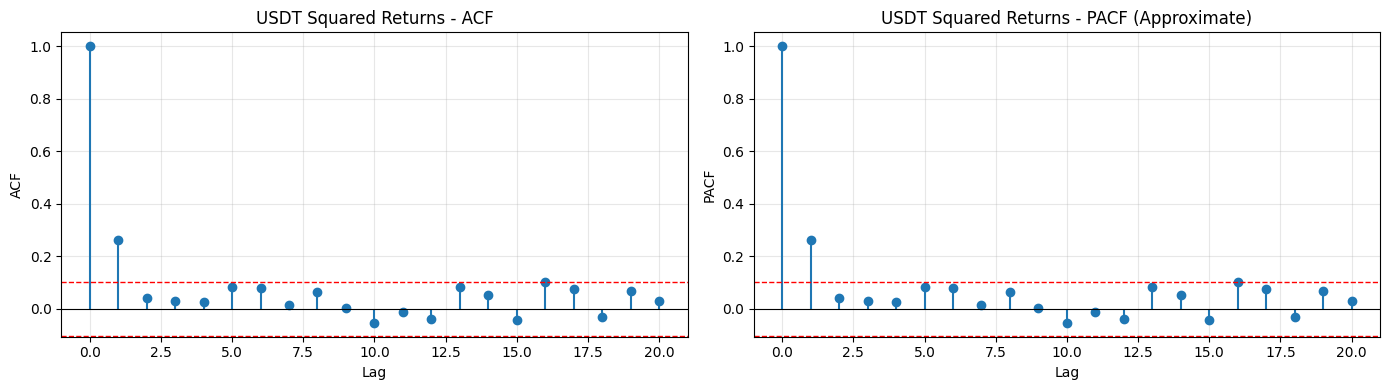

In [25]:
plot_acf_pacf(usdt_1y['Log_Return']**2, 'USDT Squared Returns', nlags=20)

# Part 7: GARCH(1,1) Model

## Define GARCH(1,1) Functions

In [26]:
def garch11_loglik(params, returns):
    """Negative log-likelihood for GARCH(1,1)"""
    omega, alpha, beta = params
    
    # Check parameter constraints
    if omega <= 0 or alpha < 0 or beta < 0 or alpha + beta >= 1:
        return 1e10
    
    n = len(returns)
    sigma2 = np.zeros(n)
    sigma2[0] = returns.var()
    
    # Recursively calculate conditional variance
    for t in range(1, n):
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]
    
    # Calculate log-likelihood
    loglik = -0.5 * np.sum(np.log(2 * np.pi * sigma2) + returns**2 / sigma2)
    return -loglik

def fit_garch11(returns):
    """Fit GARCH(1,1) model using maximum likelihood"""
    # Initial values
    x0 = [returns.var() * 0.01, 0.05, 0.90]
    
    # Optimize
    result = minimize(garch11_loglik, x0, args=(returns.values,), 
                     method='L-BFGS-B',
                     bounds=[(1e-6, None), (0, 1), (0, 1)])
    
    if result.success:
        omega, alpha, beta = result.x
        loglik = -result.fun
        return omega, alpha, beta, loglik
    else:
        return None, None, None, None

## Fit GARCH(1,1) Models

In [27]:
# Fit GARCH(1,1) for all assets
garch_results = pd.DataFrame(columns=[
    'Asset','Omega','Alpha','Beta','Alpha_Beta_Sum',
    'Log_Likelihood','Unconditional_Var','Stationary'
])

for i, (name, returns) in enumerate([
    ('AAPL', aapl_1y['Log_Return']),
    ('QQQ', qqq_1y['Log_Return']),
    ('USDT', usdt_1y['Log_Return'])
]):
    print('Fitting GARCH(1,1) for', name, '...')
    omega, alpha, beta, loglik = fit_garch11(returns)

    if omega is not None:
        garch_results.loc[i] = [
            name,
            omega,
            alpha,
            beta,
            alpha + beta,
            loglik,
            omega / (1 - alpha - beta),
            'Yes' if alpha + beta < 1 else 'No'
        ]
    else:
        garch_results.loc[i] = [name, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 'No']
        print('Optimization failed for', name)

garch_results


Fitting GARCH(1,1) for AAPL ...
Fitting GARCH(1,1) for QQQ ...
Fitting GARCH(1,1) for USDT ...


,Asset,Omega,Alpha,Beta,Alpha_Beta_Sum,Log_Likelihood,Unconditional_Var,Stationary
0,AAPL,0.000014,0.050000,0.900000,0.950000,658.590522,0.000273,Yes
1,QQQ,0.000010,0.135295,0.819194,0.954489,717.831345,0.000214,Yes
2,USDT,0.000001,0.000000,0.000000,0.000000,2166.089418,0.000001,Yes


## Conditional Volatility Plot

In [28]:
def calculate_conditional_volatility(returns, omega, alpha, beta):
    """Calculate conditional volatility from GARCH parameters"""
    n = len(returns)
    sigma2 = np.zeros(n)
    sigma2[0] = returns.var()
    
    for t in range(1, n):
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]
    
    return np.sqrt(sigma2)

# Calculate conditional volatilities
omega_aapl = garch_results.loc[0, 'Omega']
alpha_aapl = garch_results.loc[0, 'Alpha']
beta_aapl = garch_results.loc[0, 'Beta']
aapl_cond_vol = calculate_conditional_volatility(aapl_1y['Log_Return'].values, 
                                                  omega_aapl, alpha_aapl, beta_aapl)

omega_qqq = garch_results.loc[1, 'Omega']
alpha_qqq = garch_results.loc[1, 'Alpha']
beta_qqq = garch_results.loc[1, 'Beta']
qqq_cond_vol = calculate_conditional_volatility(qqq_1y['Log_Return'].values, 
                                                 omega_qqq, alpha_qqq, beta_qqq)

omega_usdt = garch_results.loc[2, 'Omega']
alpha_usdt = garch_results.loc[2, 'Alpha']
beta_usdt = garch_results.loc[2, 'Beta']
usdt_cond_vol = calculate_conditional_volatility(usdt_1y['Log_Return'].values, 
                                                  omega_usdt, alpha_usdt, beta_usdt)

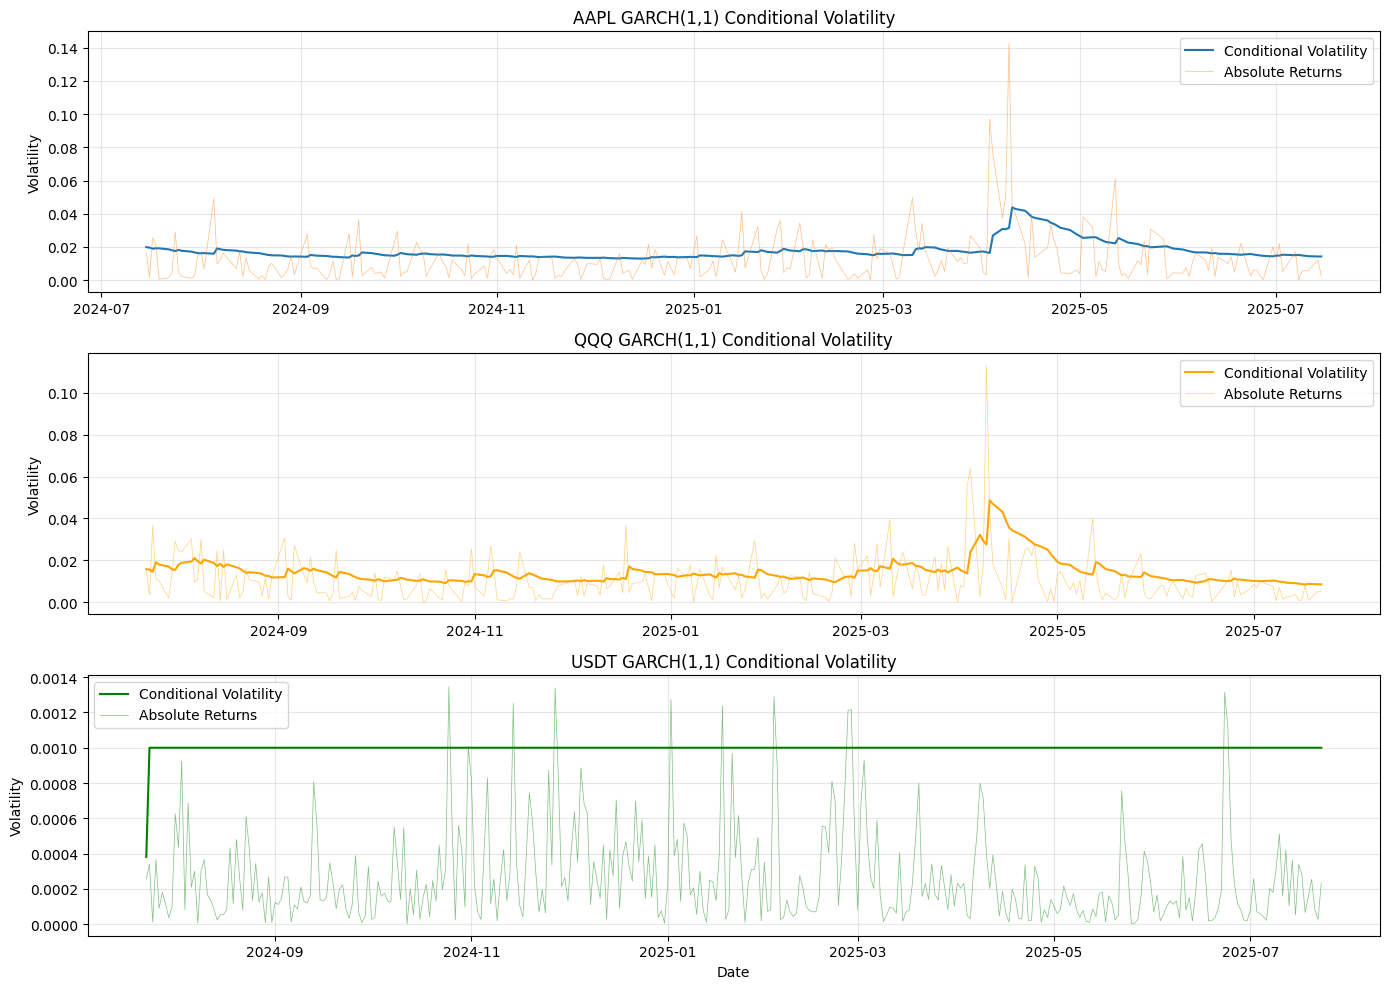

In [29]:
# Plot conditional volatility
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(aapl_1y['Date'], aapl_cond_vol, linewidth=1.5, label='Conditional Volatility')
axes[0].plot(aapl_1y['Date'], abs(aapl_1y['Log_Return']), linewidth=0.5, 
             alpha=0.5, label='Absolute Returns')
axes[0].set_title('AAPL GARCH(1,1) Conditional Volatility')
axes[0].set_ylabel('Volatility')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(qqq_1y['Date'], qqq_cond_vol, linewidth=1.5, color='orange', 
             label='Conditional Volatility')
axes[1].plot(qqq_1y['Date'], abs(qqq_1y['Log_Return']), linewidth=0.5, 
             alpha=0.5, color='orange', label='Absolute Returns')
axes[1].set_title('QQQ GARCH(1,1) Conditional Volatility')
axes[1].set_ylabel('Volatility')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(usdt_1y['Date'], usdt_cond_vol, linewidth=1.5, color='green', 
             label='Conditional Volatility')
axes[2].plot(usdt_1y['Date'], abs(usdt_1y['Log_Return']), linewidth=0.5, 
             alpha=0.5, color='green', label='Absolute Returns')
axes[2].set_title('USDT GARCH(1,1) Conditional Volatility')
axes[2].set_ylabel('Volatility')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Part 8: Value at Risk (VaR)

## Historical VaR

In [30]:
# Calculate historical VaR at 95% and 99% confidence levels
var_historical = pd.DataFrame(columns=['Asset','VaR_95','VaR_99'])

for i, (name, returns) in enumerate([
    ('AAPL', aapl_1y['Log_Return']),
    ('QQQ', qqq_1y['Log_Return']),
    ('USDT', usdt_1y['Log_Return'])
]):
    var_95 = -np.percentile(returns, 5)  
    var_99 = -np.percentile(returns, 1) 
    var_historical.loc[i] = [name, var_95, var_99]

var_historical


,Asset,VaR_95,VaR_99
0,AAPL,0.032200,0.050398
1,QQQ,0.026917,0.041495
2,USDT,0.000616,0.001150


## Parametric VaR (Normal Distribution)

In [31]:
# Calculate parametric VaR assuming normal distribution
var_parametric = pd.DataFrame(columns=['Asset','VaR_95','VaR_99'])

for i, (name, returns) in enumerate([
    ('AAPL', aapl_1y['Log_Return']),
    ('QQQ', qqq_1y['Log_Return']),
    ('USDT', usdt_1y['Log_Return'])
]):
    mean = returns.mean()
    std = returns.std()

    z_95 = stats.norm.ppf(0.05)
    z_99 = stats.norm.ppf(0.01)

    var_95 = -(mean + z_95 * std)
    var_99 = -(mean + z_99 * std)

    var_parametric.loc[i] = [name, var_95, var_99]

var_parametric


,Asset,VaR_95,VaR_99
0,AAPL,0.033204,0.046808
1,QQQ,0.025317,0.036090
2,USDT,0.000628,0.000888


## VaR Visualization

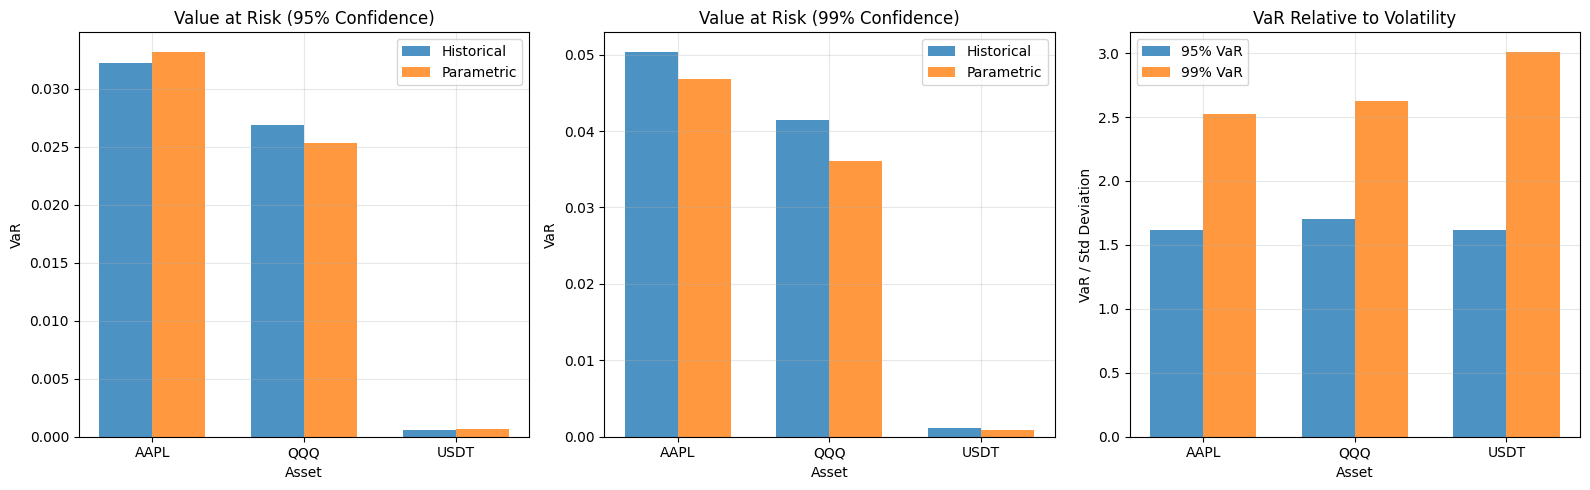

In [32]:
# Compare VaR methods
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

assets = ['AAPL', 'QQQ', 'USDT']
x = np.arange(len(assets))
width = 0.35

# 95% VaR comparison
axes[0].bar(x - width/2, var_historical['VaR_95'], width, label='Historical', alpha=0.8)
axes[0].bar(x + width/2, var_parametric['VaR_95'], width, label='Parametric', alpha=0.8)
axes[0].set_xlabel('Asset')
axes[0].set_ylabel('VaR')
axes[0].set_title('Value at Risk (95% Confidence)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(assets)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 99% VaR comparison
axes[1].bar(x - width/2, var_historical['VaR_99'], width, label='Historical', alpha=0.8)
axes[1].bar(x + width/2, var_parametric['VaR_99'], width, label='Parametric', alpha=0.8)
axes[1].set_xlabel('Asset')
axes[1].set_ylabel('VaR')
axes[1].set_title('Value at Risk (99% Confidence)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(assets)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# VaR as percentage of volatility
std_vals = [aapl_1y['Log_Return'].std(), qqq_1y['Log_Return'].std(), usdt_1y['Log_Return'].std()]
var_ratio_95 = var_historical['VaR_95'] / std_vals
var_ratio_99 = var_historical['VaR_99'] / std_vals

axes[2].bar(x - width/2, var_ratio_95, width, label='95% VaR', alpha=0.8)
axes[2].bar(x + width/2, var_ratio_99, width, label='99% VaR', alpha=0.8)
axes[2].set_xlabel('Asset')
axes[2].set_ylabel('VaR / Std Deviation')
axes[2].set_title('VaR Relative to Volatility')
axes[2].set_xticks(x)
axes[2].set_xticklabels(assets)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Part 9: Cross-Asset Analysis

## Correlation Analysis

In [33]:
# Merge data on common dates
merged = aapl_1y[['Date', 'Log_Return']].rename(columns={'Log_Return': 'AAPL'})
merged = merged.merge(qqq_1y[['Date', 'Log_Return']].rename(columns={'Log_Return': 'QQQ'}), on='Date')
merged = merged.merge(usdt_1y[['Date', 'Log_Return']].rename(columns={'Log_Return': 'USDT'}), on='Date')
merged = merged.dropna()

print('Common observations:', len(merged))

# Calculate correlation matrix
corr_matrix = merged[['AAPL', 'QQQ', 'USDT']].corr()
corr_matrix

Common observations: 245


,AAPL,QQQ,USDT
AAPL,1.000000,0.733972,0.039537
QQQ,0.733972,1.000000,0.239000
USDT,0.039537,0.239000,1.000000


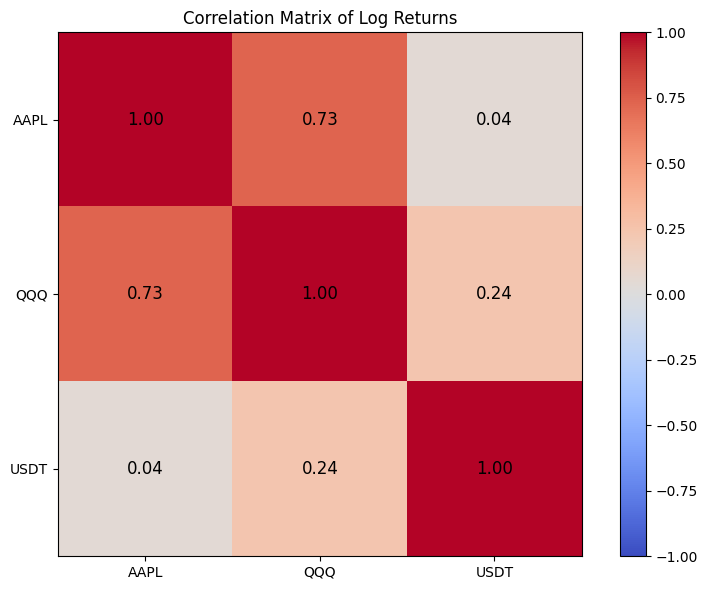

In [34]:
# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns)
ax.set_yticklabels(corr_matrix.columns)

# Add correlation values
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, '{:.2f}'.format(corr_matrix.iloc[i, j]),
                      ha="center", va="center", color="black", fontsize=12)

ax.set_title('Correlation Matrix of Log Returns')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

## Scatter Plots

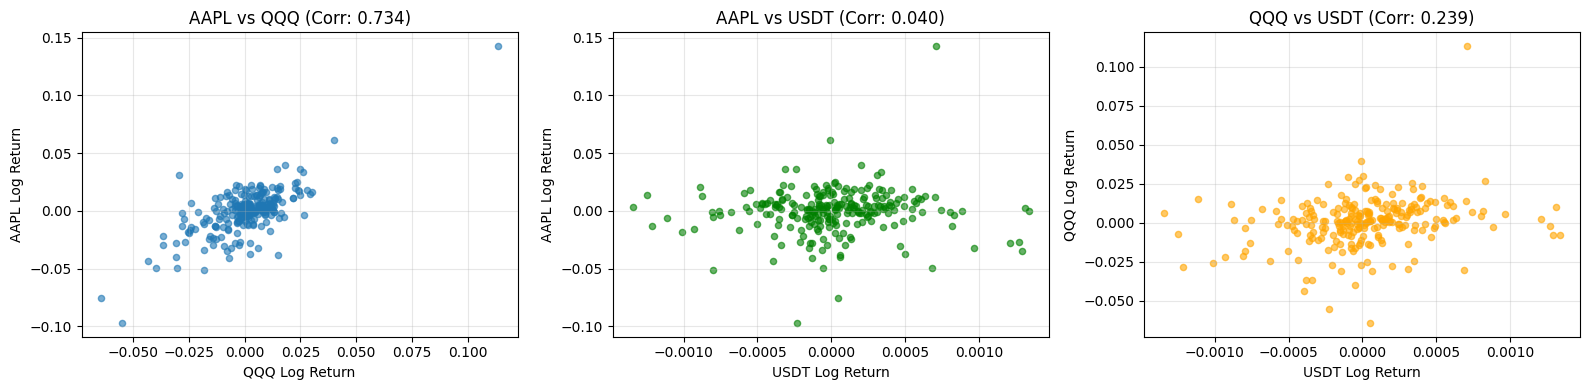

In [35]:
# Scatter plots of returns
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# AAPL vs QQQ
axes[0].scatter(merged['QQQ'], merged['AAPL'], alpha=0.6, s=20)
axes[0].set_xlabel('QQQ Log Return')
axes[0].set_ylabel('AAPL Log Return')
axes[0].set_title('AAPL vs QQQ (Corr: {:.3f})'.format(corr_matrix.loc['AAPL', 'QQQ']))
axes[0].grid(True, alpha=0.3)

# AAPL vs USDT
axes[1].scatter(merged['USDT'], merged['AAPL'], alpha=0.6, s=20, color='green')
axes[1].set_xlabel('USDT Log Return')
axes[1].set_ylabel('AAPL Log Return')
axes[1].set_title('AAPL vs USDT (Corr: {:.3f})'.format(corr_matrix.loc['AAPL', 'USDT']))
axes[1].grid(True, alpha=0.3)

# QQQ vs USDT
axes[2].scatter(merged['USDT'], merged['QQQ'], alpha=0.6, s=20, color='orange')
axes[2].set_xlabel('USDT Log Return')
axes[2].set_ylabel('QQQ Log Return')
axes[2].set_title('QQQ vs USDT (Corr: {:.3f})'.format(corr_matrix.loc['QQQ', 'USDT']))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Linear Regression: QQQ → USDT

In [36]:
def simple_regression(X, y):
    """Simple linear regression with statistics"""
    X_with_const = np.column_stack([np.ones(len(X)), X])
    beta = np.linalg.lstsq(X_with_const, y, rcond=None)[0]
    y_pred = X_with_const @ beta
    residuals = y - y_pred
    
    n = len(y)
    k = 2
    rss = np.sum(residuals**2)
    tss = np.sum((y - y.mean())**2)
    r_squared = 1 - rss / tss
    
    sigma2 = rss / (n - k)
    var_beta = sigma2 * np.linalg.inv(X_with_const.T @ X_with_const)
    se_beta = np.sqrt(np.diag(var_beta))
    
    t_stats = beta / se_beta
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), n - k))
    
    return beta, se_beta, p_values, r_squared, residuals

# Contemporaneous regression
beta_cont, se_cont, p_cont, r2_cont, resid_cont = simple_regression(
    merged['QQQ'].values, merged['USDT'].values)

regression_cont = pd.DataFrame({
    'Coefficient': ['Intercept', 'QQQ'],
    'Estimate': beta_cont,
    'Std_Error': se_cont,
    'P_Value': p_cont
})

print('Contemporaneous Regression: USDT_t = a + b * QQQ_t + e_t')
print(regression_cont)
print('R-squared:', r2_cont)

Contemporaneous Regression: USDT_t = a + b * QQQ_t + e_t
  Coefficient  Estimate  Std_Error   P_Value
0   Intercept  0.000008   0.000026  0.758879
1         QQQ  0.006332   0.001650  0.000159
R-squared: 0.05712118663796195


In [37]:
# Lagged regression
merged_lag = merged.copy()
merged_lag['QQQ_lag1'] = merged_lag['QQQ'].shift(1)
merged_lag = merged_lag.dropna()

beta_lag, se_lag, p_lag, r2_lag, resid_lag = simple_regression(
    merged_lag['QQQ_lag1'].values, merged_lag['USDT'].values)

regression_lag = pd.DataFrame({
    'Coefficient': ['Intercept', 'QQQ_lag1'],
    'Estimate': beta_lag,
    'Std_Error': se_lag,
    'P_Value': p_lag
})

print('Lagged Regression: USDT_t = a + b * QQQ_{t-1} + e_t')
print(regression_lag)
print('R-squared:', r2_lag)

Lagged Regression: USDT_t = a + b * QQQ_{t-1} + e_t
  Coefficient  Estimate  Std_Error   P_Value
0   Intercept  0.000015   0.000027  0.572415
1    QQQ_lag1 -0.003601   0.001686  0.033667
R-squared: 0.018507865365750997


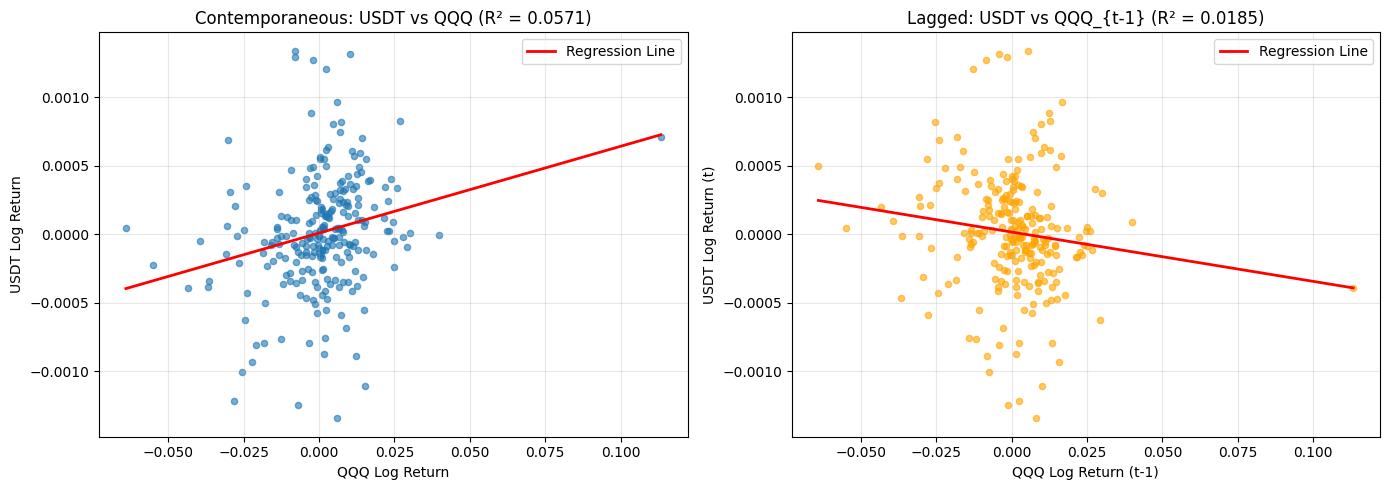

In [38]:
# Visualize regression results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Contemporaneous
axes[0].scatter(merged['QQQ'], merged['USDT'], alpha=0.6, s=20)
x_range = np.linspace(merged['QQQ'].min(), merged['QQQ'].max(), 100)
y_pred = beta_cont[0] + beta_cont[1] * x_range
axes[0].plot(x_range, y_pred, 'r-', linewidth=2, label='Regression Line')
axes[0].set_xlabel('QQQ Log Return')
axes[0].set_ylabel('USDT Log Return')
axes[0].set_title('Contemporaneous: USDT vs QQQ (R² = {:.4f})'.format(r2_cont))
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Lagged
axes[1].scatter(merged_lag['QQQ_lag1'], merged_lag['USDT'], alpha=0.6, s=20, color='orange')
x_range_lag = np.linspace(merged_lag['QQQ_lag1'].min(), merged_lag['QQQ_lag1'].max(), 100)
y_pred_lag = beta_lag[0] + beta_lag[1] * x_range_lag
axes[1].plot(x_range_lag, y_pred_lag, 'r-', linewidth=2, label='Regression Line')
axes[1].set_xlabel('QQQ Log Return (t-1)')
axes[1].set_ylabel('USDT Log Return (t)')
axes[1].set_title('Lagged: USDT vs QQQ_{{t-1}} (R² = {:.4f})'.format(r2_lag))
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Part 10: Summary and Comparison

## Model Summary Table

In [39]:
model_summary = pd.DataFrame({
    'Asset': ['AAPL', 'QQQ', 'USDT'],
    'N_Obs': [len(aapl_1y), len(qqq_1y), len(usdt_1y)],
    'Mean_Return': summary_stats['Mean'].values,
    'Std_Return': summary_stats['Std'].values,
    'Skewness': summary_stats['Skewness'].values,
    'Kurtosis': summary_stats['Kurtosis'].values,
    'Random_Walk': naive_results['Reject_RW'].values,
    'ARCH_Effects': arch_test['ARCH_Effects'].values,
    'GARCH_Alpha': garch_results['Alpha'].values,
    'GARCH_Beta': garch_results['Beta'].values,
    'VaR_95': var_historical['VaR_95'].values,
    'VaR_99': var_historical['VaR_99'].values
})

model_summary

,Asset,N_Obs,Mean_Return,Std_Return,Skewness,Kurtosis,Random_Walk,ARCH_Effects,GARCH_Alpha,GARCH_Beta,VaR_95,VaR_99
0,AAPL,251,-3.701120e-04,0.019962,0.583782,12.435998,No,Yes,0.050000,0.900000,0.032200,0.050398
1,QQQ,251,6.851578e-04,0.015808,0.698226,11.000370,No,Yes,0.135295,0.819194,0.026917,0.041495
2,USDT,366,2.288680e-07,0.000382,0.046537,2.239374,Yes,Yes,0.000000,0.000000,0.000616,0.001150


## Comparative Visualization

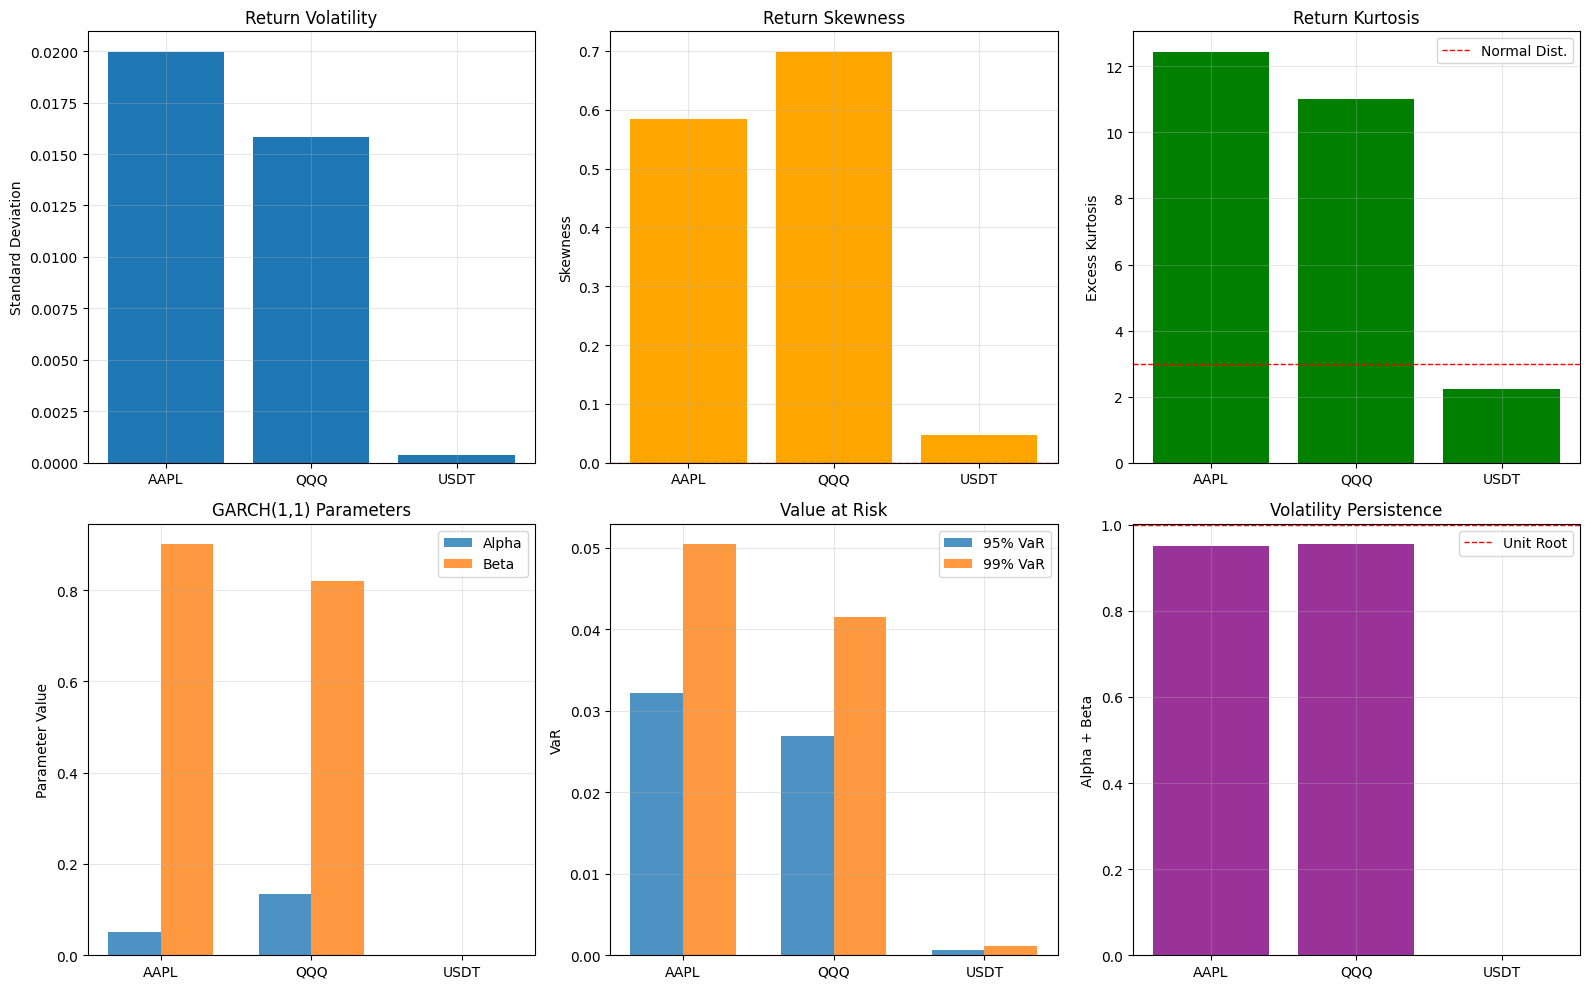

In [40]:
# Compare key metrics across assets
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

assets = ['AAPL', 'QQQ', 'USDT']
x = np.arange(len(assets))

# Volatility comparison
axes[0, 0].bar(x, model_summary['Std_Return'])
axes[0, 0].set_ylabel('Standard Deviation')
axes[0, 0].set_title('Return Volatility')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(assets)
axes[0, 0].grid(True, alpha=0.3)

# Skewness comparison
axes[0, 1].bar(x, model_summary['Skewness'], color='orange')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 1].set_ylabel('Skewness')
axes[0, 1].set_title('Return Skewness')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(assets)
axes[0, 1].grid(True, alpha=0.3)

# Kurtosis comparison
axes[0, 2].bar(x, model_summary['Kurtosis'], color='green')
axes[0, 2].axhline(y=3, color='red', linestyle='--', linewidth=1, label='Normal Dist.')
axes[0, 2].set_ylabel('Excess Kurtosis')
axes[0, 2].set_title('Return Kurtosis')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(assets)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# GARCH parameters
width = 0.35
axes[1, 0].bar(x - width/2, model_summary['GARCH_Alpha'], width, label='Alpha', alpha=0.8)
axes[1, 0].bar(x + width/2, model_summary['GARCH_Beta'], width, label='Beta', alpha=0.8)
axes[1, 0].set_ylabel('Parameter Value')
axes[1, 0].set_title('GARCH(1,1) Parameters')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(assets)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# VaR comparison
axes[1, 1].bar(x - width/2, model_summary['VaR_95'], width, label='95% VaR', alpha=0.8)
axes[1, 1].bar(x + width/2, model_summary['VaR_99'], width, label='99% VaR', alpha=0.8)
axes[1, 1].set_ylabel('VaR')
axes[1, 1].set_title('Value at Risk')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(assets)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Persistence (Alpha + Beta)
persistence = model_summary['GARCH_Alpha'] + model_summary['GARCH_Beta']
axes[1, 2].bar(x, persistence, color='purple', alpha=0.8)
axes[1, 2].axhline(y=1, color='red', linestyle='--', linewidth=1, label='Unit Root')
axes[1, 2].set_ylabel('Alpha + Beta')
axes[1, 2].set_title('Volatility Persistence')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(assets)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()